# Compare TNS Transients to DESI Targets

Access a list of transients reported to the [Transient Name Server](https://wis-tns.weizmann.ac.il/) (TNS) between Jan. 1 2020 and Mar. 25, 2020. See if any of our fibers happened to be pointing at publicly reported transients.

Note: TNS is the primary IAU database for reporting public transients. It includes alerts from all major optical transient facilities and surveys such as ZTF, PTF, ASASSN, etc.

In [1]:
from desispec.io import read_spectra
from desispec.coaddition import coadd_cameras
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution

import redrock.templates

rrtemplates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    rrtemplates[(t.template_type, t.sub_type)] = t

from astropy import units as u
from astropy.table import Table, vstack, hstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from datetime import datetime, timedelta

from scipy.ndimage import gaussian_filter1d

import os
from glob import glob

import psycopg2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [2]:
mpl.rc('font', size=14)
mpl.rc('figure', max_open_warning = 0)

## Plotting Scripts

In [3]:
import requests

def get_cutout(targetid, ra, dec, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    os.makedirs('_cache', exist_ok=True)
    img_name = f'_cache/cutout_{targetid}.jpg'
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&%22/pix=0.25&layer=dr8&size=180'.format(ra, dec)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.25/3600,
        'CRPIX1': 90,
        'CRVAL1': ra,
        'NAXIS1': 180,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.25/3600,
        'CRPIX2': 90,
        'CRVAL2': dec,
        'NAXIS2': 180
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [4]:
# Emission and absorption lines from Prospect tables.
emi_lines = Table.read('emission_lines.txt', format='ascii', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = Table.read('absorption_lines.txt', format='ascii', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']

In [68]:
def plot_alert_spectra(spectab, specpath='/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative', savefig=False, clearfig=False, rrmodel=False, targetids=None):
    """Plot spectra and image cutouts from a selected table.
    
    Paramters
    ---------
    spectab : astropy.Table
        Table of spectrum properties: merger of DESITRIP + TNS object data.
    specpath : str
        Path on disk to spectrum files created by DESITRIP.
    savefig : bool
        If true, save figures to a output files (PNG format).
    clearfig : bool
        If true, clear figures after saving. Only enabled when savefig=True.
    rrmodel : bool
        If true, compute and draw the redrock best-fit templates.
    targetids : None, list, or ndarray
        List of TARGETIDs to select from spectab.
    """
    if targetids is not None:
        idx = np.in1d(spectab['TARGETID'], targetids)
        spectab = spectab[idx]
    
    for spec in spectab:
        specfile = f'{specpath}/{spec["TILEID"]}/{spec["NIGHT"]}/coadd-{spec["PETAL_LOC"]}-{spec["TILEID"]}-thru{spec["NIGHT"]}.fits'
        spectra = read_spectra(specfile)
        spectra = coadd_cameras(spectra)
        idx = np.argwhere(np.in1d(spectra.fibermap['TARGETID'], spec['TARGETID']))[0][0]
        
        fmap = spectra.fibermap[idx]
        targetid = fmap['TARGETID']
        tileid = spec['TILEID']
        ra, dec = spec['FIBER_RA'], spec['FIBER_DEC']
        night = spec['NIGHT']
        
        zbfile = specfile.replace('coadd', 'redrock')
        if os.path.exists(zbfile):
            zbest = Table.read(zbfile, 'REDSHIFTS')
        else:
            zbfile = specfile.replace('coadd', 'zbest')
            zbest = Table.read(zbfile, 'ZBEST')
        jdx = np.argwhere(np.in1d(zbest['TARGETID'], spec['TARGETID']))[0][0]
        zdesi = zbest[jdx]['Z']
        z = zdesi
        
        # if not np.ma.is_masked(spec['Redshift']):
        #     ztns = spec['Redshift']
        #     z = ztns
        
        # dtlabel = spec['CNNLABEL']
        name = spec['Name']
        objtype = spec['Obj. Type']
        mag = spec['Discovery Mag/Flux']
        filt = spec['Discovery Filter']
        
        wave = spectra.wave['brz']
        flux = spectra.flux['brz'][idx]
        restwave = wave / (1+z)
        
        if rrmodel:
            spectype = zbest['SPECTYPE'][jdx].strip()
            subtype = zbest['SUBTYPE'][jdx].strip()
            fulltype = (spectype, subtype)
            ncoeff = rrtemplates[fulltype].flux.shape[0]
            coeff = zbest['COEFF'][jdx][0:ncoeff]
            
            tflux = rrtemplates[fulltype].flux.T.dot(coeff)
            twave = rrtemplates[fulltype].wave * (1+z)
            
            R = Resolution(spectra.resolution_data['brz'][idx])
            txflux = R.dot(resample_flux(wave, twave, tflux))
        
        if clearfig:
            if savefig:
                fig = plt.figure(num=1, figsize=(20.5,5), clear=True)
        else:
            fig = plt.figure(figsize=(20.5,5))
        fig.patch.set_alpha(0)
        
        gs = mpl.gridspec.GridSpec(1,2, width_ratios=[3,1.1])
        ax = fig.add_subplot(gs[0])
        
        smoothed = gaussian_filter1d(flux, 7)
        fmin = 2 * np.floor(np.min(smoothed)/2)
        fmax = 2 * np.ceil(np.max(smoothed)/2)
        
        label = f'TNS Disc. Mag: {mag} ({filt})'
        # label = f'DESITRIP: {dtlabel}\n{name}'
        if not np.ma.is_masked(objtype):
            label = f'{label}\n'
            label = r'{}TNS: {}, $z_\mathrm{{TNS}}={{{:.3f}}}$'.format(label, objtype, spec['Redshift'])
            
        # Time difference between discovery date and DESI observation.
        discdate = datetime.strptime(spec['Discovery Date (UT)'][:-4], '%Y-%m-%d %H:%M:%S')
        yy, mm, dd = night // 10000, night % 10000 // 100, night % 100
        desidate = datetime(yy, mm, dd)
        deltat = desidate - discdate
        
        # title = r'TARGETID={}, {}, $z={{{:.3f}}}$, $\Delta t={{{:d}}}$ d'.format(targetid, night, z, deltat.days)
        title = r'TARGETID={}, {:d}, $z_\mathrm{{DESI}}={{{:.3f}}}$, $\Delta t={{{:d}}}$d'.format(targetid, night, zdesi, deltat.days)
                
        ax.plot(restwave, smoothed, 'k', lw=2, alpha=0.6, label=label)
        
        if rrmodel:
            smoothed = gaussian_filter1d(txflux, 7)
            ax.plot(restwave, smoothed, 'r', lw=1, alpha=0.6, label=f'Model Fit: {spectype} {subtype}')
        
        ax.set(xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
               xlim=(restwave[0], restwave[-1]),
               ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
               ylim=(fmin, fmax),
               title=title
              )
        
        for eline in emi_lines_major:
            wl = eline['lambda']#*(1 + z)
            if wl > restwave[0] and wl < restwave[-1]:
                ax.axvline(wl, ls='--', color='k', alpha=0.3)
                y = 0.9*fmin if fmin < 0 else 1.1*fmin
                ax.text(wl+20, y, eline['name'], fontsize=8, rotation=90, alpha=0.3)

        for aline in abs_lines_major:
            wl = aline['lambda']#*(1 + z)
            if wl > restwave[0] and wl < restwave[-1]:
                ax.axvline(wl, ls='--', color='r', alpha=0.3)
                ax.text(wl+20, 0.9*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)
        
        ax.legend(fontsize=14, loc='best')
        
        # Plot the image cutout.
        img_file, wcs = get_cutout(targetid, ra, dec)
        img = mpl.image.imread(img_file)

        ax = fig.add_subplot(gs[1], projection=wcs)
        ax.imshow(np.flip(img, axis=0))
        overlay = ax.get_coords_overlay('icrs')
        overlay.grid(color='white', ls='dotted');

        # Add the location of the SDSS and DESI fibers.
        # DESI fiber diameters are 107 um with 70 um/" plate scale.
        r = SphericalCircle((ra * u.deg, dec * u.deg), 1.5 * u.arcsec,
                         edgecolor='lime', facecolor='none', alpha=0.8, ls='--',
                         transform=ax.get_transform('icrs'))
        ax.add_patch(r)
        
        alert_coord = SkyCoord(ra=spec['RA'], dec=spec['DEC'], unit=['hourangle', 'degree'])
        print(ra, dec, targetid, tileid)
        print(alert_coord.ra, alert_coord.dec)
        ax.scatter(alert_coord.ra, alert_coord.dec, color='r', marker='*', transform=ax.get_transform('world'))
        
        ax.set(#aspect='equal',
               xlabel='ra',
               ylabel='dec')
        
        if savefig:
            os.makedirs('_output', exist_ok=True)
            img_name = '_output/desitrip_tns_{}_{}.png'.format(night, targetid)
            fig.savefig(img_name, facecolor=fig.get_facecolor(), dpi=100)

## Load TNS Data

All-sky from TNS were downloaded using the [tns_download script](https://github.com/desihub/timedomain/blob/master/tns/tns_download.py) available in the timedomain repository.

In [6]:
tns_all = Table.read('/global/project/projectdirs/desi/science/td/tns/tns_all_alerts.csv', format='csv')
tns_all

ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
int64,str11,str12,str12,str17,float64,str32,float64,str59,str52,str33,str52,str29,str107,str52,int64,int64,str10,float64,str12,str23,str20,str134,int64
97463,AT 2021agdc,19:33:23.020,+19:58:48.07,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21fld,Gaia - Gaia-photometric,--,1,1,--,14.13,G-Gaia,2021-12-05 03:40:19.200,Gaia_Bot1,--,--
97462,AT 2021agdb,07:05:51.780,-54:34:18.01,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21flc,Gaia - Gaia-photometric,--,1,1,--,17.54,G-Gaia,2021-12-04 19:20:38.400,Gaia_Bot1,--,--
97461,AT 2021agda,01:07:13.010,-80:19:31.30,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21fla,Gaia - Gaia-photometric,--,1,1,--,18.48,G-Gaia,2021-12-05 07:53:45.600,Gaia_Bot1,--,--
97460,AT 2021agcz,21:38:01.370,-74:25:18.52,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21fkz,Gaia - Gaia-photometric,--,1,1,--,17.01,G-Gaia,2021-12-04 20:03:50.400,Gaia_Bot1,--,--
97459,AT 2021agcy,23:53:52.010,-80:12:02.45,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21fky,Gaia - Gaia-photometric,--,1,1,--,18.7,G-Gaia,2021-12-05 01:56:38.400,Gaia_Bot1,--,--
97458,AT 2021agcx,09:38:27.160,+72:54:14.65,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21fkx,Gaia - Gaia-photometric,--,1,1,--,16.46,G-Gaia,2021-12-04 23:12:28.800,Gaia_Bot1,--,--
97456,AT 2021agcw,12:52:11.555,+29:38:28.75,--,--,--,--,ZTF,ZTF,--,ZTF,ZTF21acramdb,P48 - ZTF-Cam,--,1,1,--,18.9941,r-ZTF,2021-11-07 12:44:38.400,ZTF_CLU_PUBLIC,--,--
97455,AT 2021agcv,07:43:14.390,-20:00:44.78,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21fkw,Gaia - Gaia-photometric,--,1,1,--,18.72,G-Gaia,2021-12-04 02:34:04.800,Gaia_Bot1,--,--
97454,AT 2021agcu,19:48:13.040,+12:08:14.10,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21fkv,Gaia - Gaia-photometric,--,1,1,--,17.82,G-Gaia,2021-12-03 23:16:48.000,Gaia_Bot1,--,--


In [7]:
def plot_radec(ra, dec):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    ra : pandas.Series or list
        List of candidate RA [deg].
    dec : pandas.Series or list
        List of candidate Dec [deg].
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    # Convert RA, Dec to radians.
    # Rotate the RA so that the plot goes 360->0 left to right.
    _ra = np.radians(180 - ra)
    _dec = np.radians(dec)

    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    ax.scatter(_ra, _dec, alpha=0.5, s=10)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    fig.tight_layout()
    
    return fig;

In [8]:
tns_all_coords = SkyCoord(ra=tns_all['RA'], dec=tns_all['DEC'], unit=['hourangle', 'degree'])

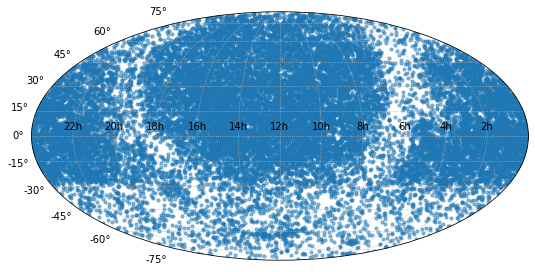

In [9]:
fig = plot_radec(tns_all_coords.ra.to_value('deg'), tns_all_coords.dec.to_value('deg'))
fig.savefig('tns_coords_all.png', dpi=100)

## Load Daily Fiber Observations and Compare to TNS

In [10]:
use_cached = True

if os.path.exists('/global/project/projectdirs/desi/science/td/tns/desi_targets.fits') and use_cached:
    desi_targets = Table.read('/global/project/projectdirs/desi/science/td/tns/desi_targets.fits')
else:
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desi', user='desi')
        cursor = db.cursor()

        query = """SELECT DISTINCT fd.targetid, fd.tileid, fd.petal_loc, fd.night, fd.fiber_ra, fd.fiber_dec, zd.z, zd.zwarn, zd.deltachi2
                   FROM fibermap_daily as fd
                   INNER JOIN zbest_daily zd
                       ON zd.targetid = fd.targetid
                   WHERE (fd.targetid > 0);"""

        cursor.execute(query)
        rows = cursor.fetchall()
        desi_targets = Table(list(map(list, zip(*rows))),
                             names=['TARGETID', 'TILEID', 'PETAL_LOC', 'NIGHT',
                                    'FIBER_RA', 'FIBER_DEC',
                                    'Z', 'ZWARN', 'DELTACHI2',])

        desi_targets['FIBER_RA'].unit = 'degree'
        desi_targets['FIBER_DEC'].unit = 'degree'
        
        desi_targets.write('/global/project/projectdirs/desi/science/td/tns/desi_targets.fits', overwrite=True)
        
    except (Exception, psycopg2.Error) as error:
        print(error)
    finally:
        if db is not None:
            db.close()

goodz = (desi_targets['ZWARN'] == 0) & (desi_targets['DELTACHI2'] > 25)
desi_targets = desi_targets[goodz]

desi_targets

TARGETID,TILEID,PETAL_LOC,NIGHT,FIBER_RA,FIBER_DEC,Z,ZWARN,DELTACHI2
,,,,deg,deg,,,
int64,int64,int64,int64,float64,float64,float64,int64,float64
6448025174016,80856,3,20210309,179.156565385525,28.4234555712068,0.0221933367215889,0,150.27181740012
6448025174016,80856,3,20210309,179.156610892703,28.4234683571171,0.0221933367215889,0,150.27181740012
6448025174016,80856,3,20210316,179.156615540748,28.4235048176165,0.0221933367215889,0,150.27181740012
6448025174016,80856,3,20210317,179.15654266003,28.4234592879762,0.0221933367215889,0,150.27181740012
6448025174016,80856,3,20210317,179.156642892197,28.4235294735109,0.0221933367215889,0,150.27181740012
6448025174016,80856,3,20210318,179.156610937457,28.4234845327255,0.0221933367215889,0,150.27181740012
6521555517440,80889,8,20210318,204.227533081798,32.0949135595685,0.3238872170838,0,35.1305918991566
6521555517440,80889,8,20210319,204.227494806498,32.0949299886393,0.3238872170838,0,35.1305918991566


In [11]:
uid, udx = np.unique(desi_targets['TARGETID'], return_index=True)

In [12]:
# desi_coords = SkyCoord(ra=desi_targets['TARGET_RA'][udx], dec=desi_targets['TARGET_DEC'][udx], unit='degree')
desi_coords = SkyCoord(ra=desi_targets['FIBER_RA'], dec=desi_targets['FIBER_DEC'], unit='degree')

In [13]:
len(desi_coords)

22052184

### Match All Transients within about 1 Fiber Diameter of a Fiber

In [14]:
idx, sep2d, sep3d = match_coordinates_sky(tns_all_coords, desi_coords)

In [15]:
matched = sep2d < 2*u.arcsec
idx_tns = np.argwhere(matched).ravel()
idx_desi = idx[idx_tns]

In [16]:
tns_all[idx_tns]

ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
int64,str11,str12,str12,str17,float64,str32,float64,str59,str52,str33,str52,str29,str107,str52,int64,int64,str10,float64,str12,str23,str20,str134,int64
97361,AT 2021afzf,13:54:46.298,+04:51:37.33,--,--,SDSS J135446.24+045137.9,--,ALeRCE,ZTF,--,ALeRCE,ZTF21acrchxm,P48 - ZTF-Cam,--,1,1,--,20.1196,r-ZTF,2021-12-02 13:02:20.999,ALeRCE,--,--
97331,SN 2021afyb,22:15:02.165,-09:30:20.40,SN Ia,0.086,WISEA J221502.13-093020.7,0.08404299999999999,ALeRCE,ZTF,ZTF,ALeRCE,ZTF21acqpapq,P48 - ZTF-Cam,P60 - SEDM,1,1,--,18.7634,r-ZTF,2021-12-02 02:27:37.002,ALeRCE,--,--
97325,AT 2021afxv,00:53:13.916,+09:02:14.46,--,--,SDSS J005313.91+090216.1,--,ALeRCE,ZTF,--,ALeRCE,ZTF21acqpwql,P48 - ZTF-Cam,--,1,1,--,20.0773,r-ZTF,2021-12-02 03:35:03.002,ALeRCE,--,--
97306,AT 2021afxc,07:02:50.447,+68:01:08.37,--,--,WISEA J070250.48+680108.7,--,ALeRCE,ZTF,--,ALeRCE,ZTF21acqtxmv,P48 - ZTF-Cam,--,1,1,--,19.9592,r-ZTF,2021-12-02 08:21:57.001,ALeRCE,--,--
97297,AT 2021afwt,08:37:28.024,+12:44:53.08,--,--,WISEA J083728.00+124453.4,0.09150900000000001,ALeRCE,ZTF,--,ALeRCE,ZTF21acqvzoj,P48 - ZTF-Cam,--,1,1,--,19.4734,r-ZTF,2021-12-02 08:37:07.000,ALeRCE,--,--
97253,AT 2021afvd,12:57:55.379,+25:06:03.05,--,--,--,--,ZTF,ZTF,--,ZTF,ZTF21acqndda,P48 - ZTF-Cam,--,1,1,--,19.36,r-ZTF,2021-11-20 11:47:02.400,ZTF_Bot1,--,--
97242,AT 2021afus,08:02:34.183,+14:21:29.24,--,--,SDSS J080234.16+142129.0,--,SGLF,ZTF,--,SGLF,ZTF21acpvtgf,P48 - ZTF-Cam,--,1,1,--,20.352,r-ZTF,2021-11-18 11:35:15.000,Perez-Fournon,--,--
97209,AT 2021aftm,07:43:43.513,+37:55:58.76,--,--,--,--,YSE,Pan-STARRS1,--,Pan-STARRS1; YSE,PS21neu,PS1 - GPC1,--,1,1,--,20.1,r-Sloan,2021-11-08 14:39:50.400,YSE_Bot1,--,--
97194,AT 2021afsx,03:50:05.572,-08:28:29.49,--,--,--,--,Pan-STARRS1,Pan-STARRS1,--,Pan-STARRS1,PS21nep,PS1 - GPC1,--,1,1,--,20.12,w-PS1,2021-11-28 10:23:31.200,PS1_Bot1,--,--


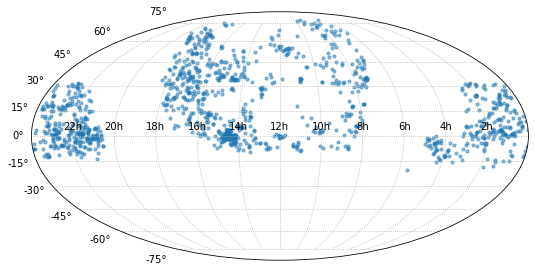

In [18]:
fig = plot_radec(tns_all_coords[idx_tns].ra.to_value('deg'), tns_all_coords[idx_tns].dec.to_value('deg'))
fig.savefig('tns_coords_match_desi.png', dpi=100)

In [19]:
desi_targets[idx_desi]

TARGETID,TILEID,PETAL_LOC,NIGHT,FIBER_RA,FIBER_DEC,Z,ZWARN,DELTACHI2
,,,,deg,deg,,,
int64,int64,int64,int64,float64,float64,float64,int64,float64
39627902915971004,457,2,20210505,208.692619042468,4.86058008020044,0.124738054413047,0,5429.97116518021
39627561659008697,22426,9,20211107,333.758883956273,-9.50574323833673,0.0840320646461966,0,4939.73019309947
39628001683442440,22603,3,20211203,13.3079753566461,9.037824032214,0.0834537259142609,0,11721.298119545
39633471764695853,26005,3,20211116,105.710124429041,68.0190421582594,0.0962509995586242,0,1247.54950982332
39628092670477499,22932,0,20211021,129.366692636592,12.7481773315633,0.0915001084044286,0,2744.42447747663
39628373642709785,501,4,20210511,194.480968447794,25.1004841205412,0.11987816365319,0,5324.62540084124
2715323438465026,10206,2,20211112,120.642397548323,14.358067229635,0.139583397663477,0,612.413118530065
39633038396622967,22532,2,20211021,115.930780130777,37.9329214738916,-8.96431658789975e-05,0,293.433461251861


### Merge the Matched Fibermap and TNS Lists

In [20]:
matched_targets = hstack([desi_targets[idx_desi], tns_all[idx_tns]])

In [21]:
matched_targets

TARGETID,TILEID,PETAL_LOC,NIGHT,FIBER_RA,FIBER_DEC,Z,ZWARN,DELTACHI2,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,int64,int64,int64,float64,float64,float64,int64,float64,int64,str11,str12,str12,str17,float64,str32,float64,str59,str52,str33,str52,str29,str107,str52,int64,int64,str10,float64,str12,str23,str20,str134,int64
39627902915971004,457,2,20210505,208.692619042468,4.86058008020044,0.124738054413047,0,5429.97116518021,97361,AT 2021afzf,13:54:46.298,+04:51:37.33,--,--,SDSS J135446.24+045137.9,--,ALeRCE,ZTF,--,ALeRCE,ZTF21acrchxm,P48 - ZTF-Cam,--,1,1,--,20.1196,r-ZTF,2021-12-02 13:02:20.999,ALeRCE,--,--
39627561659008697,22426,9,20211107,333.758883956273,-9.50574323833673,0.0840320646461966,0,4939.73019309947,97331,SN 2021afyb,22:15:02.165,-09:30:20.40,SN Ia,0.086,WISEA J221502.13-093020.7,0.08404299999999999,ALeRCE,ZTF,ZTF,ALeRCE,ZTF21acqpapq,P48 - ZTF-Cam,P60 - SEDM,1,1,--,18.7634,r-ZTF,2021-12-02 02:27:37.002,ALeRCE,--,--
39628001683442440,22603,3,20211203,13.3079753566461,9.037824032214,0.0834537259142609,0,11721.298119545,97325,AT 2021afxv,00:53:13.916,+09:02:14.46,--,--,SDSS J005313.91+090216.1,--,ALeRCE,ZTF,--,ALeRCE,ZTF21acqpwql,P48 - ZTF-Cam,--,1,1,--,20.0773,r-ZTF,2021-12-02 03:35:03.002,ALeRCE,--,--
39633471764695853,26005,3,20211116,105.710124429041,68.0190421582594,0.0962509995586242,0,1247.54950982332,97306,AT 2021afxc,07:02:50.447,+68:01:08.37,--,--,WISEA J070250.48+680108.7,--,ALeRCE,ZTF,--,ALeRCE,ZTF21acqtxmv,P48 - ZTF-Cam,--,1,1,--,19.9592,r-ZTF,2021-12-02 08:21:57.001,ALeRCE,--,--
39628092670477499,22932,0,20211021,129.366692636592,12.7481773315633,0.0915001084044286,0,2744.42447747663,97297,AT 2021afwt,08:37:28.024,+12:44:53.08,--,--,WISEA J083728.00+124453.4,0.09150900000000001,ALeRCE,ZTF,--,ALeRCE,ZTF21acqvzoj,P48 - ZTF-Cam,--,1,1,--,19.4734,r-ZTF,2021-12-02 08:37:07.000,ALeRCE,--,--
39628373642709785,501,4,20210511,194.480968447794,25.1004841205412,0.11987816365319,0,5324.62540084124,97253,AT 2021afvd,12:57:55.379,+25:06:03.05,--,--,--,--,ZTF,ZTF,--,ZTF,ZTF21acqndda,P48 - ZTF-Cam,--,1,1,--,19.36,r-ZTF,2021-11-20 11:47:02.400,ZTF_Bot1,--,--
2715323438465026,10206,2,20211112,120.642397548323,14.358067229635,0.139583397663477,0,612.413118530065,97242,AT 2021afus,08:02:34.183,+14:21:29.24,--,--,SDSS J080234.16+142129.0,--,SGLF,ZTF,--,SGLF,ZTF21acpvtgf,P48 - ZTF-Cam,--,1,1,--,20.352,r-ZTF,2021-11-18 11:35:15.000,Perez-Fournon,--,--
39633038396622967,22532,2,20211021,115.930780130777,37.9329214738916,-8.96431658789975e-05,0,293.433461251861,97209,AT 2021aftm,07:43:43.513,+37:55:58.76,--,--,--,--,YSE,Pan-STARRS1,--,Pan-STARRS1; YSE,PS21neu,PS1 - GPC1,--,1,1,--,20.1,r-Sloan,2021-11-08 14:39:50.400,YSE_Bot1,--,--


### Check Matched Targets with an Independent (non-DESI) Classification

In [20]:
matched_targets[np.logical_not(matched_targets['Obj. Type'].mask)]

TARGETID,TILEID,PETAL_LOC,NIGHT,FIBER_RA,FIBER_DEC,Z,ZWARN,DELTACHI2,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,int64,int64,int64,float64,float64,float64,int64,float64,int64,str11,str12,str12,str17,float64,str32,float64,str59,str52,str33,str52,str29,str107,str52,int64,int64,str10,float64,str12,str23,str20,str134,int64
39627561659008697,22426,9,20211107,333.758883956273,-9.50574323833673,0.0840320646461966,0,4939.73019309947,97331,SN 2021afyb,22:15:02.165,-09:30:20.40,SN Ia,0.086,WISEA J221502.13-093020.7,0.08404299999999999,ALeRCE,ZTF,ZTF,ALeRCE,ZTF21acqpapq,P48 - ZTF-Cam,P60 - SEDM,1,1,--,18.7634,r-ZTF,2021-12-02 02:27:37.002,ALeRCE,--,--
39628066930032912,24355,0,20211014,1.54153207533777,11.6255649364676,0.074395641504253,0,214.114537472837,96955,SN 2021afjw,00:06:09.844,+11:37:32.68,SN Ia,0.081,--,--,"ZTF, ATLAS","ZTF, ATLAS",ZTF,ATLAS; ZTF,ZTF21acptlvu,"ATLAS1 - ACAM1, P48 - ZTF-Cam",P60 - SEDM,1,1,--,19.37,r-ZTF,2021-11-22 04:09:07.200,ZTF_Bot1,--,--
39628007786155359,22597,5,20211201,21.2277000317651,9.20882481762358,0.0200552398544302,0,505.730865747668,96603,SN 2021aexj,01:24:54.635,+09:12:32.00,SN Ia,0.047,--,--,"ZTF, ATLAS","ZTF, ATLAS",ZTF,ATLAS; ZTF,ZTF21acptaer,"ATLAS1 - ACAM1, P48 - ZTF-Cam",P60 - SEDM,1,1,--,18.5507,r-ZTF,2021-11-19 08:19:07.104,ZTF_CLU_PUBLIC,--,--
39627789925614808,22393,0,20210704,309.778549303303,0.047392248751787,0.07802462386698,0,2571.15693771839,95388,SN 2021adew,20:39:06.850,+00:02:51.09,SN Ia,0.078,WISEA J203906.81+000249.9,0.07802100000000001,"ALeRCE, YSE, ATLAS","ZTF, Pan-STARRS1, ATLAS",UCSC,ALeRCE; ATLAS; Pan-STARRS1; YSE,ZTF21ackmlae,"ATLAS1 - ACAM1, P48 - ZTF-Cam, PS1 - GPC1",Keck1 - LRIS,1,1,--,19.8318,r-ZTF,2021-11-03 03:08:30.002,ALeRCE,--,--
39627681385417178,20841,1,20210621,317.703494529917,-4.3761688722729,0.13274353616338,0,658.386852294207,95140,SN 2021acvp,21:10:48.828,-04:22:33.38,SN Ia,0.12,--,--,YSE,Pan-STARRS1,UCSC,Pan-STARRS1; YSE,PS21lrw,PS1 - GPC1,Lick-3m - KAST,1,1,--,20.73,r-Sloan,2021-10-31 05:02:24.000,YSE_Bot1,--,--
39627771965605251,25534,3,20210921,319.276361695397,-0.703084318629857,0.0606723982414,0,7401.80295300484,94636,SN 2021accm,21:17:06.314,-00:42:11.75,SN Ib,0.061,--,--,"YSE, Pan-STARRS1, ATLAS","Pan-STARRS1, ATLAS",UCSC,ATLAS; Pan-STARRS1; YSE,PS21ljm,"ATLAS1 - ACAM1, PS1 - GPC1",Keck1 - LRIS,1,1,--,20.09,r-Sloan,2021-10-20 06:46:04.800,YSE_Bot1,--,--
39628338024677823,25512,5,20211016,30.5303427333269,23.5498343967443,0.0158527372003633,0,54147.8377424766,94140,SN 2021abko,02:02:07.256,+23:33:00.91,SN Ia,0.015908000000000002,IC 0190,0.015908000000000002,"ASAS-SN, ZTF, AMPEL","ASAS-SN, ZTF","None, ePESSTO+",AMPEL; ASAS-SN; ZTF,ASASSN-21tk,"ASASSN-1 - Brutus, ASASSN-3 - Paczynski, P48 - ZTF-Cam","ESO-NTT - EFOSC2-NTT, Other - Other",1,1,--,16.9,g-Sloan,2021-10-14 12:28:48.000,Stanek,--,--
39628154783926812,24404,9,20211026,341.499679839684,15.2557817062004,0.115496423661818,0,2630.91454841942,93219,AT 2021aabs,22:45:59.839,+15:15:20.65,Other,--,SDSS J224559.92+151520.5,--,ALeRCE,ZTF,None,ALeRCE,ZTF21acedcny,P48 - ZTF-Cam,INT-2.5m - IDS,1,1,--,19.7271,r-ZTF,2021-09-28 05:57:23.996,ALeRCE,--,--


### Select Matched Transients with DESI Data -1 Wks to +4 Wks from TNS Discovery Date

In [22]:
discdate = [datetime.strptime(x[:-4], '%Y-%m-%d %H:%M:%S') for x in matched_targets['Discovery Date (UT)']]
night = matched_targets['NIGHT']
desidate = [datetime(n // 10000, n % 10000 // 100, n % 100) for n in night]
dt = np.asarray([(x - y).days for x, y in zip(desidate, discdate)])

In [23]:
select_close = (dt > -7) & (dt < 28)
np.sum(select_close)

183

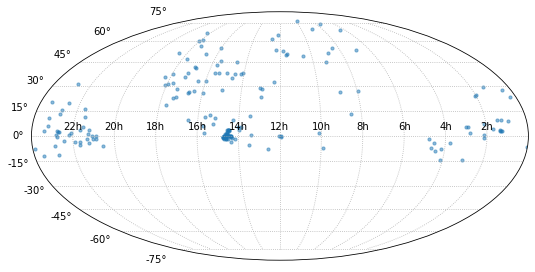

In [24]:
fig = plot_radec(tns_all_coords[idx_tns][select_close].ra.to_value('deg'), tns_all_coords[idx_tns][select_close].dec.to_value('deg'))
fig.savefig('tns_coords_match_desi_neardisc.png', dpi=100)

#### How Many Matched Targets are Classified in TNS?

In [25]:
has_class = np.logical_not(matched_targets['Obj. Type'].mask)
np.sum(has_class), np.sum(select_close & has_class)

(112, 23)

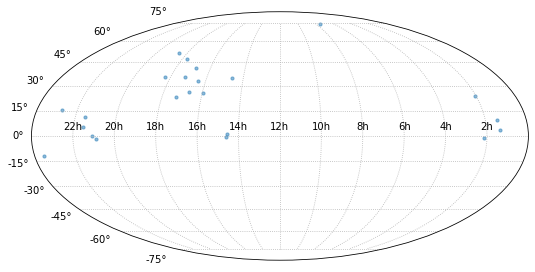

In [26]:
fig = plot_radec(tns_all_coords[idx_tns][select_close & has_class].ra.to_value('deg'), tns_all_coords[idx_tns][select_close & has_class].dec.to_value('deg'))
fig.savefig('tns_coords_match_desi_neardisc_classified.png', dpi=100)

### List Matched Targets above a Given Magnitude

In [23]:
matched_targets[select_close & (matched_targets['Discovery Mag/Flux'] < 20)]

TARGETID,TILEID,PETAL_LOC,NIGHT,FIBER_RA,FIBER_DEC,Z,ZWARN,DELTACHI2,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,Classifying Group/s,Associated Group/s,Disc. Internal Name,Disc. Instrument/s,Class. Instrument/s,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s
,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,int64,int64,int64,float64,float64,float64,int64,float64,int64,str11,str12,str12,str17,float64,str32,float64,str59,str52,str33,str52,str29,str107,str52,int64,int64,str10,float64,str12,str23,str20,str134,int64
39633491490506854,25995,0,20211125,134.167112502762,70.3227099363398,0.092441464660187,0,1741.729395926,96671,AT 2021aezu,08:56:40.046,+70:19:21.56,--,--,--,--,Pan-STARRS1,Pan-STARRS1,--,Pan-STARRS1,PS21mpc,PS1 - GPC1,--,1,1,--,19.86,i-Sloan,2021-11-21 12:23:02.400,PS1_Bot1,--,--
39628007786155359,22597,5,20211201,21.2277000317651,9.20882481762358,0.0200552398544302,0,505.730865747668,96603,SN 2021aexj,01:24:54.635,+09:12:32.00,SN Ia,0.047,--,--,"ZTF, ATLAS","ZTF, ATLAS",ZTF,ATLAS; ZTF,ZTF21acptaer,"ATLAS1 - ACAM1, P48 - ZTF-Cam",P60 - SEDM,1,1,--,18.5507,r-ZTF,2021-11-19 08:19:07.104,ZTF_CLU_PUBLIC,--,--
39633480660814348,10333,6,20211102,97.34254211922,69.0054124753195,1.6922277215009,0,525.790670156479,96365,AT 2021aepa,06:29:22.110,+69:00:19.23,--,--,--,--,AMPEL,ZTF,--,AMPEL,ZTF18abvtnko,P48 - ZTF-Cam,--,1,1,--,19.23,r-ZTF,2021-10-30 10:16:19.200,ZTF_AMPEL_COMPLETE,--,--
39628102040555220,3832,2,20211102,342.002526172548,12.9334203161725,1.28359786371181,0,9537.53522321582,95650,AT 2021adon,22:48:00.610,+12:56:00.46,--,--,--,--,GaiaAlerts,GaiaAlerts,--,GaiaAlerts,Gaia21ezv,Gaia - Gaia-photometric,--,1,1,--,18.52,G-Gaia,2021-11-04 03:40:19.200,Gaia_Bot1,--,--
39627677014951546,21438,4,20211114,56.4902699879632,-4.3920133961485,0.116465259984347,0,5434.11306174286,95618,AT 2021adni,03:45:57.637,-04:23:31.44,--,--,WISEA J034557.65-042331.2,--,ALeRCE,ZTF,--,ALeRCE,ZTF21ackthuy,P48 - ZTF-Cam,--,1,1,--,19.9666,r-ZTF,2021-11-03 08:39:46.996,ALeRCE,--,--
39627954086478327,6404,3,20211105,31.750766792982,6.96472466509721,0.243550936953114,0,140547.20844996,95569,AT 2021adlq,02:07:00.164,+06:57:53.73,--,--,--,--,ATLAS,ATLAS,--,ATLAS,ATLAS21blqh,ATLAS1 - ACAM1,--,1,1,--,19.074,cyan-ATLAS,2021-11-04 10:04:48.000,ATLAS_Bot1,--,--
39627526082923011,23658,2,20211122,341.807140399018,-11.0862203984895,0.142390916737634,0,275.445088419132,95026,AT 2021acrh,22:47:13.649,-11:05:10.02,--,--,WISEA J224713.72-110507.0,--,ALeRCE,ZTF,--,ALeRCE,ZTF21aciwegs,P48 - ZTF-Cam,--,1,1,--,19.8935,g-ZTF,2021-10-30 05:00:10.002,ALeRCE,--,--
39627624414187525,5663,7,20211110,148.517982283459,-6.83727066699989,0.596860061292752,0,5535.70767492056,94152,AT 2021abla,09:54:04.338,-06:50:14.02,--,--,--,--,ZTF,ZTF,--,ZTF,ZTF21achpbzk,P48 - ZTF-Cam,--,1,1,--,19.65,r-ZTF,2021-10-13 12:20:09.600,ZTF_Bot1,--,--


### Compare DESI and TNS Host Redshifts

In [27]:
select_tns_z = np.logical_not(matched_targets['Host Redshift'].mask)
print(np.sum(select_tns_z))
z_desi = matched_targets['Z'][select_tns_z]
z_tns = matched_targets['Host Redshift'][select_tns_z]
mag = matched_targets['Discovery Mag/Flux'][select_tns_z]

145


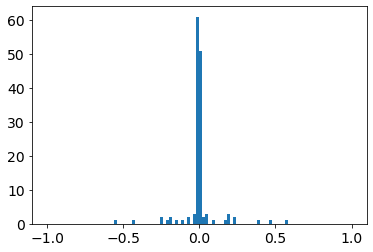

In [28]:
plt.hist((z_desi - z_tns)/z_tns, np.linspace(-1,1,101));

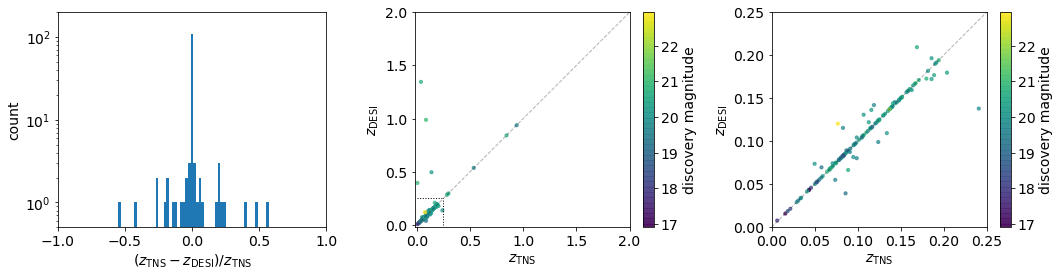

In [29]:
fig, axes = plt.subplots(1,3, figsize=(15,4))

ax = axes[0]
ax.hist((z_desi - z_tns)/z_tns, np.linspace(-0.75,0.75,76), log=True)
ax.set(xlim=(-1,1),
       xlabel=r'$(z_\mathrm{TNS} - z_\mathrm{DESI})/z_\mathrm{TNS}$',
       ylim=(0.5,200),
       ylabel='count')

zbox = 0.25

ax = axes[1]
ax.plot([0,2], [0,2], 'k--', lw=1, alpha=0.3)
ax.plot([0,zbox], [zbox,zbox], 'k:', lw=1)
ax.plot([zbox,zbox], [0,zbox], 'k:', lw=1)
sc = ax.scatter(z_tns, z_desi, alpha=0.7, s=10, c=mag)
cb = fig.colorbar(sc, ax=ax)
cb.set_label('discovery magnitude')
ax.set(aspect='equal',
       xlabel=r'$z_\mathrm{TNS}$',
       xlim=(-0.02,2),
       ylabel=r'$z_\mathrm{DESI}$',
       ylim=(-0.02,2))

ax = axes[2]
ax.plot([0,1], [0,1], 'k--', lw=1, alpha=0.3)
sc = ax.scatter(z_tns, z_desi, alpha=0.7, s=10, c=mag)
cb = fig.colorbar(sc, ax=ax)
cb.set_label('discovery magnitude')
ax.set(aspect='equal',
       xlabel=r'$z_\mathrm{TNS}$',
       xlim=(0,zbox),
       ylabel=r'$z_\mathrm{DESI}$',
       ylim=(0,zbox))

fig.tight_layout();
fig.savefig('desi_vs_tns_redshift.png', dpi=100)

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  3.,  3.,  1.,  4.,  6.,  8., 11., 10., 16.,
        14., 19., 18.,  8.,  7.,  3.,  5.,  6.,  8.,  4.,  4.,  6.,  8.,
         3.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. ,
        17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2,
        19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4,
        21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6,
        23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. ]),
 <a list of 50 Patch objects>)

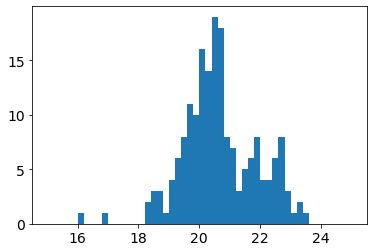

In [27]:
plt.hist(matched_targets['Discovery Mag/Flux'][select_close], bins=np.linspace(15,25,51))

## Save Spectra in Coincidence with TNS Alerts

### Interesting Redrock Failure Modes

INFO:spectra.py:282:read_spectra: iotime 0.727 sec to read coadd-6-22522-thru20211023.fits at 2021-12-09T04:44:49.387898
126.229548506654 55.1235163516768 39633321356951680 22522
126d13m46.11s 55d07m24.81s
INFO:spectra.py:282:read_spectra: iotime 0.652 sec to read coadd-5-24451-thru20211022.fits at 2021-12-09T04:44:54.140190
113.683775821016 74.3762022218903 39633522788403073 24451
113d41m01.155s 74d22m34.63s
INFO:spectra.py:282:read_spectra: iotime 0.654 sec to read coadd-1-22372-thru20210921.fits at 2021-12-09T04:44:59.003030
323.124267749356 5.34638073462804 39627916874618396 22372
323d07m27.45s 5d20m46.72s
INFO:spectra.py:282:read_spectra: iotime 0.723 sec to read coadd-8-20850-thru20210609.fits at 2021-12-09T04:45:03.798984
322.886655728829 11.1490478831314 39628060370142531 20850
322d53m12s 11d08m56.36s


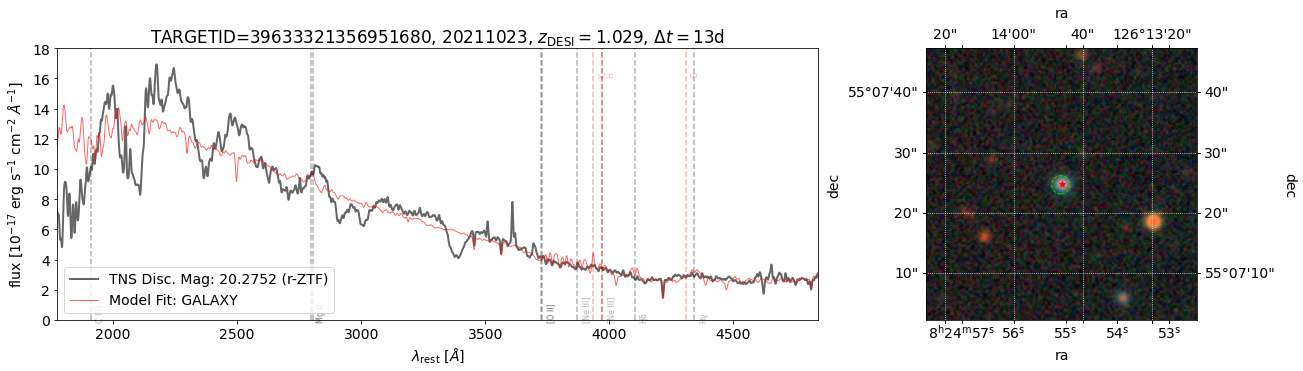

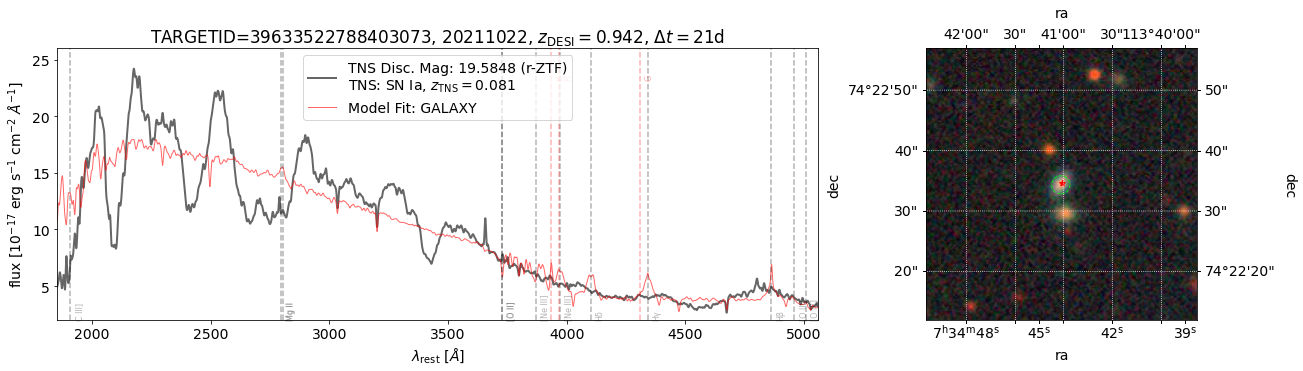

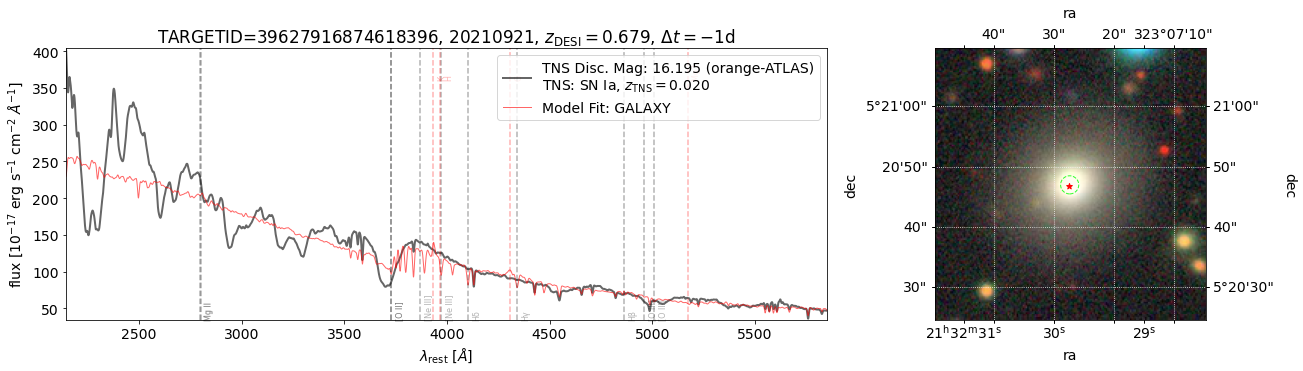

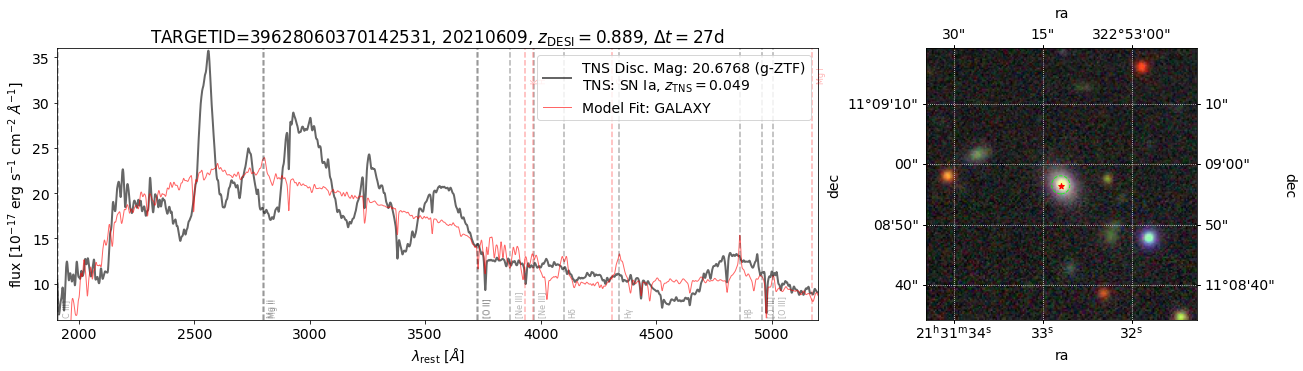

In [30]:
plot_alert_spectra(matched_targets[select_close],
                   targetids=[39628060370142531, 39627916874618396, 39633522788403073, 39633321356951680],
                   rrmodel=True,
                   savefig=True)

### TNS + DESI Spectra with Classifications for Both

INFO:spectra.py:282:read_spectra: iotime 0.777 sec to read coadd-9-24011-thru20211001.fits at 2021-12-09T04:45:17.793133
274.410806365407 35.7901454637572 39632996944316930 24011
274d24m37.2s 35d47m23.39s
INFO:spectra.py:282:read_spectra: iotime 0.742 sec to read coadd-0-20895-thru20210628.fits at 2021-12-09T04:45:23.091116
265.493001051323 47.1045247733538 39633200862986949 20895
265d29m34.755s 47d06m16.19s


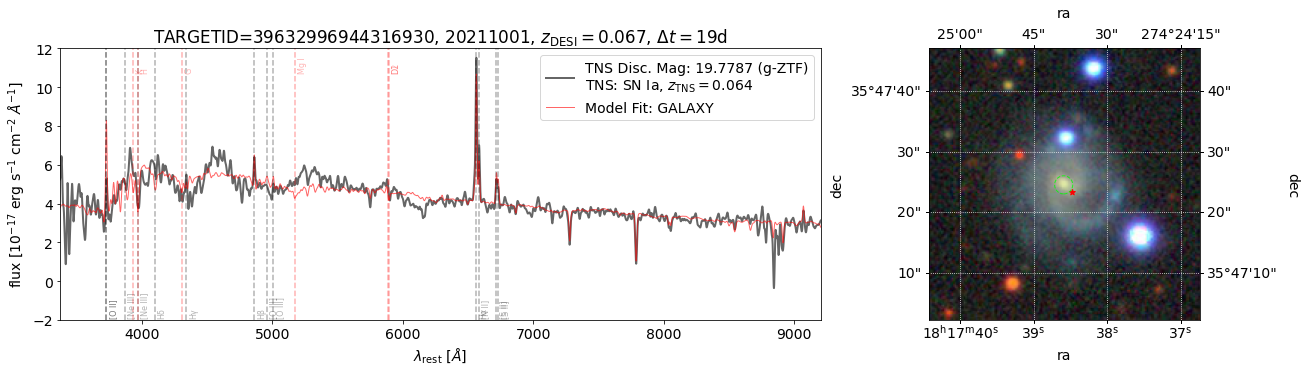

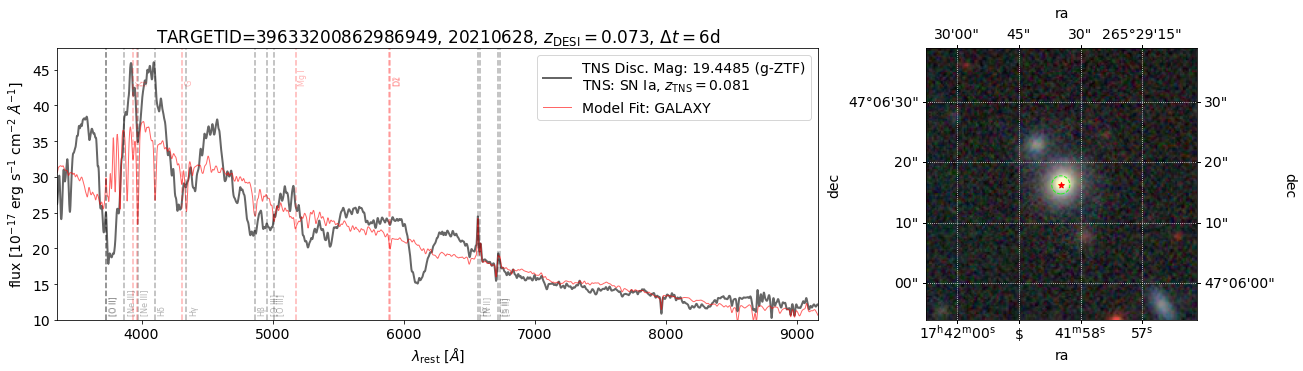

In [31]:
plot_alert_spectra(matched_targets,
                   targetids=[39633200862986949, 39632996944316930],
                   rrmodel=True,
                   savefig=True)

### TNS + DESI Spectra with Only DESI Classifications

There are many more objects with only DESITRIP classifications... this is just to make some nice public plots.

INFO:spectra.py:282:read_spectra: iotime 0.731 sec to read coadd-4-21438-thru20211114.fits at 2021-12-09T04:46:43.139855
56.4902699879632 -4.3920133961485 39627677014951546 21438
56d29m24.555s -4d23m31.44s
INFO:spectra.py:282:read_spectra: iotime 0.691 sec to read coadd-3-20733-thru20210619.fits at 2021-12-09T04:46:48.062045
232.958147210138 45.6971945290916 39633179593671725 20733
232d57m30.405s 45d41m50.36s


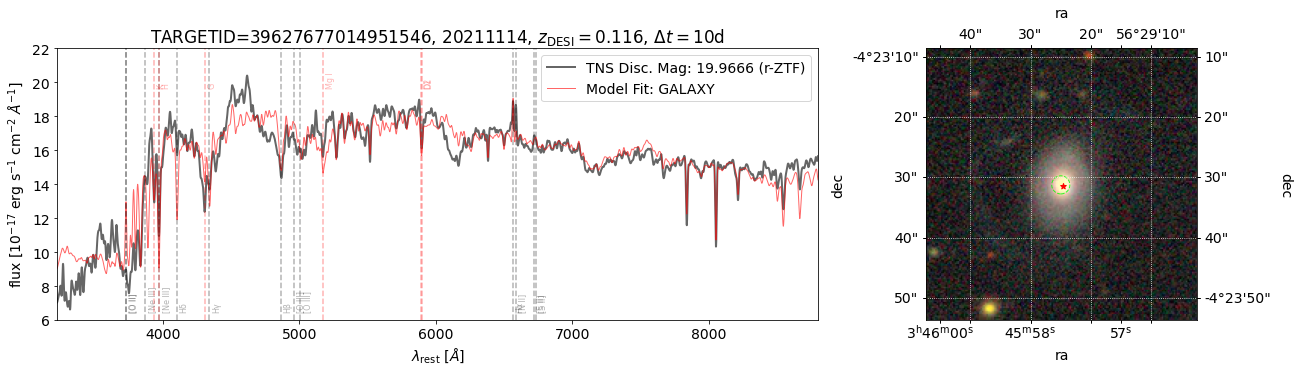

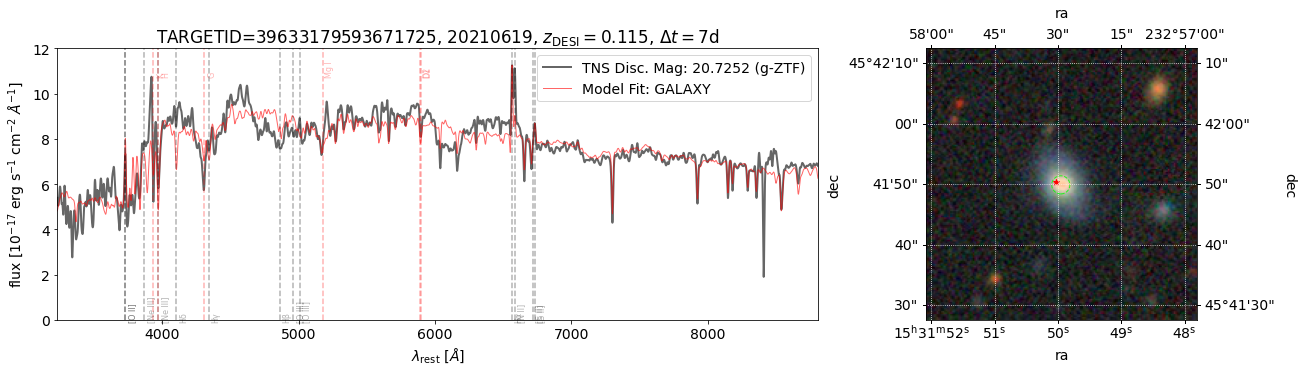

In [32]:
plot_alert_spectra(matched_targets,
                   targetids=[39633179593671725, 39627677014951546],
                   rrmodel=True,
                   savefig=True)

### Loop through All Matches and Store the DESI Spectra and Cutouts

INFO:spectra.py:282:read_spectra: iotime 0.467 sec to read coadd-3-22603-thru20211203.fits at 2021-12-09T07:07:34.885705
13.3079753566461 9.037824032214 39628001683442440 22603
13d18m28.74s 9d02m14.46s


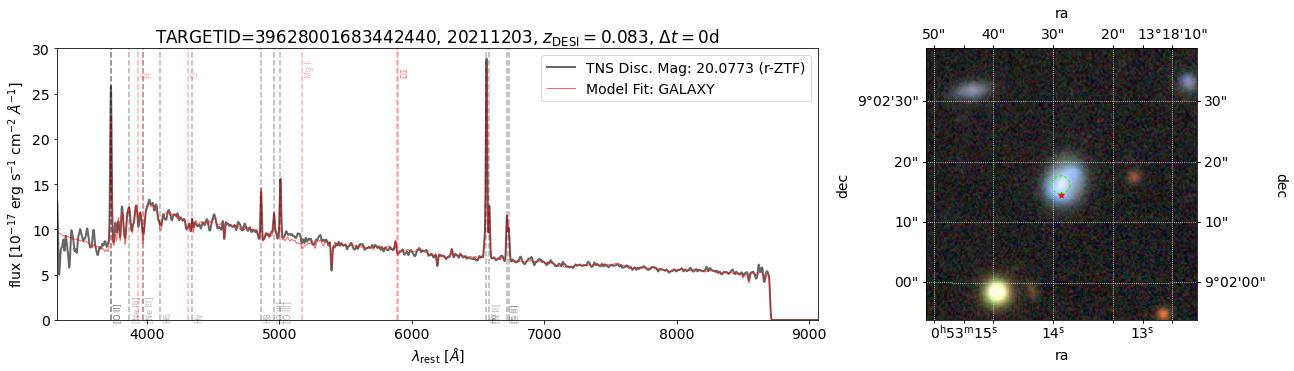

In [69]:
# plot_alert_spectra(matched_targets[select_close & (matched_targets['Discovery Mag/Flux'] < 20)], savefig=True)
plot_alert_spectra(matched_targets[select_close][:1], savefig=True, clearfig=True, rrmodel=True)

#### Create HTML Index of Spectra

In [70]:
with open('index.html', 'w') as f:
    f.write('<html>\n<head><title>TNS Alerts</title><style type="text/css">table { border-collapse: collapse; } tr.rowhighlight {background-color:#f0f8ff;margin:0;border:0;padding:0;} </style></head><body>\n<table style="border-spacing: 10px;">\n')
    imgs = sorted(glob('_output/*.png'))
    for img in imgs:
        tok = img.split('_')
        night = int(tok[-2])
        targetid = int(tok[-1][:-4])
        
        i = np.in1d(matched_targets['TARGETID'], targetid)
        name = matched_targets['Name'][i][0]
        tns_id = name.split()[-1]
        objtype = matched_targets['Obj. Type'][i][0]
        mag = '{:.3f}'.format(matched_targets['Discovery Mag/Flux'][i][0])
        filt = matched_targets['Discovery Filter'][i][0]
        z_desi = '{:.3f}'.format(matched_targets['Z'][i][0])
        if not np.ma.is_masked(objtype):
            obj = f'<br /><strong>{objtype}</strong>'
            f.write('<tr class="rowhighlight">\n')
        else:
            obj = ''
            f.write('<tr>\n')
        
        f.write(f'<td><a href="{img}"><img src="{img}" width="600px" /></a></td>\n')
        f.write(f'<td>DESI:<br />Date: {night}<br /> TARGETID: <a href="https://www.legacysurvey.org/viewer-desi/?zoom=15&targetid={targetid}" target="_blank">{targetid}</a><br /><em>z</em><sub>DESI</sub>: {z_desi}</td>\n')
        f.write(f'<td>TNS:<br />Name: <a href="https://www.wis-tns.org/object/{tns_id}" target="_blank">{name}</a><br />Disc. Mag.: {mag}<br />Disc. Filt: {filt} {obj}</td>\n')
        f.write('</tr>\n')
    f.write('</table>\n</body>\n</html>')